In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laptop-price/laptop_price.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from xgboost import XGBRegressor


In [3]:
df = pd.read_csv('/kaggle/input/laptop-price/laptop_price.csv', encoding = "latin-1")
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [4]:
df.Company.value_counts()

Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64

In [5]:
df.Product.value_counts()

Product
XPS 13                                     30
Inspiron 3567                              29
250 G6                                     21
Legion Y520-15IKBN                         19
Vostro 3568                                19
                                           ..
15-bw007nv (A10-9620P/6GB/128GB/Radeon      1
SmartBook 130                               1
A541NA-GO342 (N3350/4GB/500GB/Linux)        1
17-X047na (i3-6006U/8GB/1TB/W10)            1
V330-15IKB (i5-8250U/4GB/500GB/FHD/W10)     1
Name: count, Length: 618, dtype: int64

In [6]:
df = df.drop("Product", axis=1)

In [7]:
pd.get_dummies(df.Company)

,Acer,Apple,Asus,Chuwi,Dell,Fujitsu,Google,HP,Huawei,LG,Lenovo,MSI,Mediacom,Microsoft,Razer,Samsung,Toshiba,Vero,Xiaomi
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1299,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1300,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
1301,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Company',
 'TypeName',
 'ScreenResolution',
 'Cpu',
 'Ram',
 'Memory',
 'Gpu',
 'OpSys',
 'Weight']

In [9]:
categorical_columns = df[["Company", "TypeName", "OpSys"]].columns.tolist()
categorical_columns 

['Company', 'TypeName', 'OpSys']

In [10]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_encoded

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [11]:
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded

,laptop_ID,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,...,TypeName_Workstation,OpSys_Android,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS
0,1,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,1.83kg,2537.45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,1.37kg,1803.60,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,1.8kg,638.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1299,1317,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,1.3kg,1499.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1300,1318,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,1.5kg,229.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1301,1319,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,2.19kg,764.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
df_encoded['ScreenResolution'] = df_encoded['ScreenResolution'].str.split().str[-1]


In [13]:
df_encoded['ScreenResolution'].str.split("x").str[0]

0       2560
1       1440
2       1920
3       2880
4       2560
        ... 
1298    1920
1299    3200
1300    1366
1301    1366
1302    1366
Name: ScreenResolution, Length: 1303, dtype: object

In [14]:
df_encoded['ScreenWidth'] = df_encoded['ScreenResolution'].str.split("x").str[0]


In [15]:
df_encoded['ScreenHeight'] = df_encoded['ScreenResolution'].str.split("x").str[1]
df_encoded.head()

,laptop_ID,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,...,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight
0,1,13.3,2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600
1,2,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1440,900
2,3,15.6,1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1920,1080
3,4,15.4,2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,1.83kg,2537.45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2880,1800
4,5,13.3,2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,1.37kg,1803.60,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600


In [16]:
df_encoded = df_encoded.drop('ScreenResolution', axis=1)
df_encoded.head()

,laptop_ID,Inches,Cpu,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,Company_Apple,...,OpSys_Chrome OS,OpSys_Linux,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight
0,1,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600
1,2,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1440,900
2,3,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1920,1080
3,4,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,1.83kg,2537.45,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2880,1800
4,5,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,1.37kg,1803.60,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600


In [17]:
df_encoded['Cpu'].str.split().str[0]


0       Intel
1       Intel
2       Intel
3       Intel
4       Intel
        ...  
1298    Intel
1299    Intel
1300    Intel
1301    Intel
1302    Intel
Name: Cpu, Length: 1303, dtype: object

In [18]:
df_encoded['CpuBrand'] = df_encoded['Cpu'].str.split().str[0]


In [19]:
df_encoded['CpuFreq'] = df_encoded['Cpu'].str.split().str[-1]

In [20]:
df_encoded = df_encoded.drop("Cpu", axis=1)
df_encoded.head(3)

,laptop_ID,Inches,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,...,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight,CpuBrand,CpuFreq
0,1,13.3,8GB,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600,Intel,2.3GHz
1,2,13.3,8GB,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1440,900,Intel,1.8GHz
2,3,15.6,8GB,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1920,1080,Intel,2.5GHz


In [21]:
df_encoded['CpuFreq'] = df_encoded['CpuFreq'].str.replace('GHz', '').str.strip()
df_encoded.head(3)

,laptop_ID,Inches,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,...,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight,CpuBrand,CpuFreq
0,1,13.3,8GB,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600,Intel,2.3
1,2,13.3,8GB,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1440,900,Intel,1.8
2,3,15.6,8GB,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1920,1080,Intel,2.5


In [22]:
df_encoded['Ram'] = df_encoded['Ram'].str.replace('GB', '').str.strip()
df_encoded.head(3)

,laptop_ID,Inches,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,...,OpSys_Mac OS X,OpSys_No OS,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight,CpuBrand,CpuFreq
0,1,13.3,8,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2560,1600,Intel,2.3
1,2,13.3,8,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1440,900,Intel,1.8
2,3,15.6,8,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1920,1080,Intel,2.5


In [23]:
df_encoded['Ram'] = df_encoded['Ram'].astype('int')
df_encoded['CpuFreq'] = df_encoded['CpuFreq'].astype('float')
df_encoded['ScreenHeight'] = df_encoded['ScreenHeight'].astype('int')
df_encoded['ScreenWidth'] = df_encoded['ScreenWidth'].astype('int')

In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   laptop_ID                    1303 non-null   int64  
 1   Inches                       1303 non-null   float64
 2   Ram                          1303 non-null   int64  
 3   Memory                       1303 non-null   object 
 4   Gpu                          1303 non-null   object 
 5   Weight                       1303 non-null   object 
 6   Price_euros                  1303 non-null   float64
 7   Company_Acer                 1303 non-null   float64
 8   Company_Apple                1303 non-null   float64
 9   Company_Asus                 1303 non-null   float64
 10  Company_Chuwi                1303 non-null   float64
 11  Company_Dell                 1303 non-null   float64
 12  Company_Fujitsu              1303 non-null   float64
 13  Company_Google    

In [25]:
df_encoded['MemoryAmount'] = df_encoded['Memory'].str.split().str[0]
df_encoded['MemoryType'] = df_encoded['Memory'].str.split().str[1]
df_encoded

,laptop_ID,Inches,Ram,Memory,Gpu,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,...,OpSys_Windows 10,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight,CpuBrand,CpuFreq,MemoryAmount,MemoryType
0,1,13.3,8,128GB SSD,Intel Iris Plus Graphics 640,1.37kg,1339.69,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,2560,1600,Intel,2.3,128GB,SSD
1,2,13.3,8,128GB Flash Storage,Intel HD Graphics 6000,1.34kg,898.94,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1440,900,Intel,1.8,128GB,Flash
2,3,15.6,8,256GB SSD,Intel HD Graphics 620,1.86kg,575.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1920,1080,Intel,2.5,256GB,SSD
3,4,15.4,16,512GB SSD,AMD Radeon Pro 455,1.83kg,2537.45,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,2880,1800,Intel,2.7,512GB,SSD
4,5,13.3,8,256GB SSD,Intel Iris Plus Graphics 650,1.37kg,1803.60,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,2560,1600,Intel,3.1,256GB,SSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,14.0,4,128GB SSD,Intel HD Graphics 520,1.8kg,638.00,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1920,1080,Intel,2.5,128GB,SSD
1299,1317,13.3,16,512GB SSD,Intel HD Graphics 520,1.3kg,1499.00,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,3200,1800,Intel,2.5,512GB,SSD
1300,1318,14.0,2,64GB Flash Storage,Intel HD Graphics,1.5kg,229.00,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1366,768,Intel,1.6,64GB,Flash
1301,1319,15.6,6,1TB HDD,AMD Radeon R5 M330,2.19kg,764.00,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1366,768,Intel,2.5,1TB,HDD


In [26]:
def memory_to_GB(value):
    if "TB" in value:
        return float(value[:value.find("TB")]) * 1000
    elif "GB" in value:
        return float(value[:value.find("GB")]) 

In [27]:
df_encoded["MemoryAmount"].apply(memory_to_GB)


0        128.0
1        128.0
2        256.0
3        512.0
4        256.0
         ...  
1298     128.0
1299     512.0
1300      64.0
1301    1000.0
1302     500.0
Name: MemoryAmount, Length: 1303, dtype: float64

In [28]:
df_encoded["MemoryAmount"] = df_encoded["MemoryAmount"].apply(memory_to_GB)
df_encoded = df_encoded.drop("Memory", axis=1)

In [29]:
df_encoded['MemoryAmount'] = df_encoded['MemoryAmount'].astype('int')
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   laptop_ID                    1303 non-null   int64  
 1   Inches                       1303 non-null   float64
 2   Ram                          1303 non-null   int64  
 3   Gpu                          1303 non-null   object 
 4   Weight                       1303 non-null   object 
 5   Price_euros                  1303 non-null   float64
 6   Company_Acer                 1303 non-null   float64
 7   Company_Apple                1303 non-null   float64
 8   Company_Asus                 1303 non-null   float64
 9   Company_Chuwi                1303 non-null   float64
 10  Company_Dell                 1303 non-null   float64
 11  Company_Fujitsu              1303 non-null   float64
 12  Company_Google               1303 non-null   float64
 13  Company_HP        

In [30]:
df_encoded['Weight'] = df_encoded['Weight'].str.replace('kg', '').str.strip()
df_encoded['Weight'] = df_encoded['Weight'].astype('float')

In [31]:
df_encoded['GpuBrand'] = df_encoded['Gpu'].str.split().str[0]
df_encoded = df_encoded.drop("Gpu", axis=1)

In [32]:
df_encoded.head()

,laptop_ID,Inches,Ram,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,OpSys_Windows 10 S,OpSys_Windows 7,OpSys_macOS,ScreenWidth,ScreenHeight,CpuBrand,CpuFreq,MemoryAmount,MemoryType,GpuBrand
0,1,13.3,8,1.37,1339.69,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2560,1600,Intel,2.3,128,SSD,Intel
1,2,13.3,8,1.34,898.94,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1440,900,Intel,1.8,128,Flash,Intel
2,3,15.6,8,1.86,575.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1920,1080,Intel,2.5,256,SSD,Intel
3,4,15.4,16,1.83,2537.45,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2880,1800,Intel,2.7,512,SSD,AMD
4,5,13.3,8,1.37,1803.60,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2560,1600,Intel,3.1,256,SSD,Intel


In [33]:
df_encoded.dtypes

laptop_ID                        int64
Inches                         float64
Ram                              int64
Weight                         float64
Price_euros                    float64
Company_Acer                   float64
Company_Apple                  float64
Company_Asus                   float64
Company_Chuwi                  float64
Company_Dell                   float64
Company_Fujitsu                float64
Company_Google                 float64
Company_HP                     float64
Company_Huawei                 float64
Company_LG                     float64
Company_Lenovo                 float64
Company_MSI                    float64
Company_Mediacom               float64
Company_Microsoft              float64
Company_Razer                  float64
Company_Samsung                float64
Company_Toshiba                float64
Company_Vero                   float64
Company_Xiaomi                 float64
TypeName_2 in 1 Convertible    float64
TypeName_Gaming          

In [34]:
categorical_columns = df_encoded[["CpuBrand", "GpuBrand", "MemoryType"]].columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df_encoded[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded = pd.concat([df_encoded, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

In [35]:
df_encoded.dtypes


laptop_ID                        int64
Inches                         float64
Ram                              int64
Weight                         float64
Price_euros                    float64
Company_Acer                   float64
Company_Apple                  float64
Company_Asus                   float64
Company_Chuwi                  float64
Company_Dell                   float64
Company_Fujitsu                float64
Company_Google                 float64
Company_HP                     float64
Company_Huawei                 float64
Company_LG                     float64
Company_Lenovo                 float64
Company_MSI                    float64
Company_Mediacom               float64
Company_Microsoft              float64
Company_Razer                  float64
Company_Samsung                float64
Company_Toshiba                float64
Company_Vero                   float64
Company_Xiaomi                 float64
TypeName_2 in 1 Convertible    float64
TypeName_Gaming          

In [36]:
df_encoded.corr() #GpuBrand_Nvidia -> 0.348797

,laptop_ID,Inches,Ram,Weight,Price_euros,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,CpuBrand_Intel,CpuBrand_Samsung,GpuBrand_AMD,GpuBrand_ARM,GpuBrand_Intel,GpuBrand_Nvidia,MemoryType_Flash,MemoryType_HDD,MemoryType_Hybrid,MemoryType_SSD
laptop_ID,1.000000,-0.087796,-0.028607,-0.011798,0.067830,-0.057721,-0.119585,-0.044252,-0.043348,-0.013628,...,0.049765,0.039920,-0.089050,0.039920,0.094479,-0.037596,0.028792,0.050182,0.098241,-0.079509
Inches,-0.087796,1.000000,0.237993,0.827631,0.068197,0.009435,-0.158850,0.112766,-0.017426,0.045288,...,-0.122000,-0.052816,0.207023,-0.052816,-0.592264,0.486561,-0.367908,0.271145,0.026080,-0.082325
Ram,-0.028607,0.237993,1.000000,0.383874,0.743007,-0.138432,0.023950,0.088634,-0.035117,0.082241,...,0.107051,-0.023894,-0.093119,-0.023894,-0.319551,0.415464,-0.192327,-0.318614,-0.016994,0.398663
Weight,-0.011798,0.827631,0.383874,1.000000,0.210370,0.056444,-0.138191,0.101332,-0.022536,0.088465,...,-0.057386,-0.037026,0.106519,-0.037026,-0.596378,0.565232,-0.259337,0.166644,0.030970,-0.037134
Price_euros,0.067830,0.068197,0.743007,0.210370,1.000000,-0.208349,0.080688,-0.010376,-0.055646,0.048509,...,0.181127,-0.018431,-0.199415,-0.018431,-0.184205,0.348797,-0.210823,-0.426121,-0.039386,0.513609
Company_Acer,-0.057721,0.009435,-0.138432,0.056444,-0.208349,1.000000,-0.037497,-0.108831,-0.014074,-0.159187,...,-0.066566,-0.008119,-0.034859,-0.008119,0.005305,0.020848,0.086359,0.109048,-0.025765,-0.140685
Company_Apple,-0.119585,-0.158850,0.023950,-0.138191,0.080688,-0.037497,1.000000,-0.047544,-0.006148,-0.069542,...,0.028849,-0.003547,0.001749,-0.003547,0.078028,-0.085183,0.230044,-0.081359,-0.011256,-0.032982
Company_Asus,-0.044252,0.112766,0.088634,0.101332,-0.010376,-0.108831,-0.047544,1.000000,-0.017845,-0.201839,...,-0.036835,-0.010295,-0.073770,-0.010295,-0.106654,0.170742,0.049519,-0.007644,-0.032668,-0.010926
Company_Chuwi,-0.043348,-0.017426,-0.035117,-0.022536,-0.055646,-0.014074,-0.006148,-0.017845,1.000000,-0.026102,...,0.010828,-0.001331,-0.019232,-0.001331,0.043093,-0.031972,0.194383,-0.030537,-0.004225,-0.065032
Company_Dell,-0.013628,0.045288,0.082241,0.088465,0.048509,-0.159187,-0.069542,-0.201839,-0.026102,1.000000,...,0.122473,-0.015058,0.190722,-0.015058,-0.075707,-0.060187,-0.118570,0.046568,-0.005856,0.014739


<Axes: >

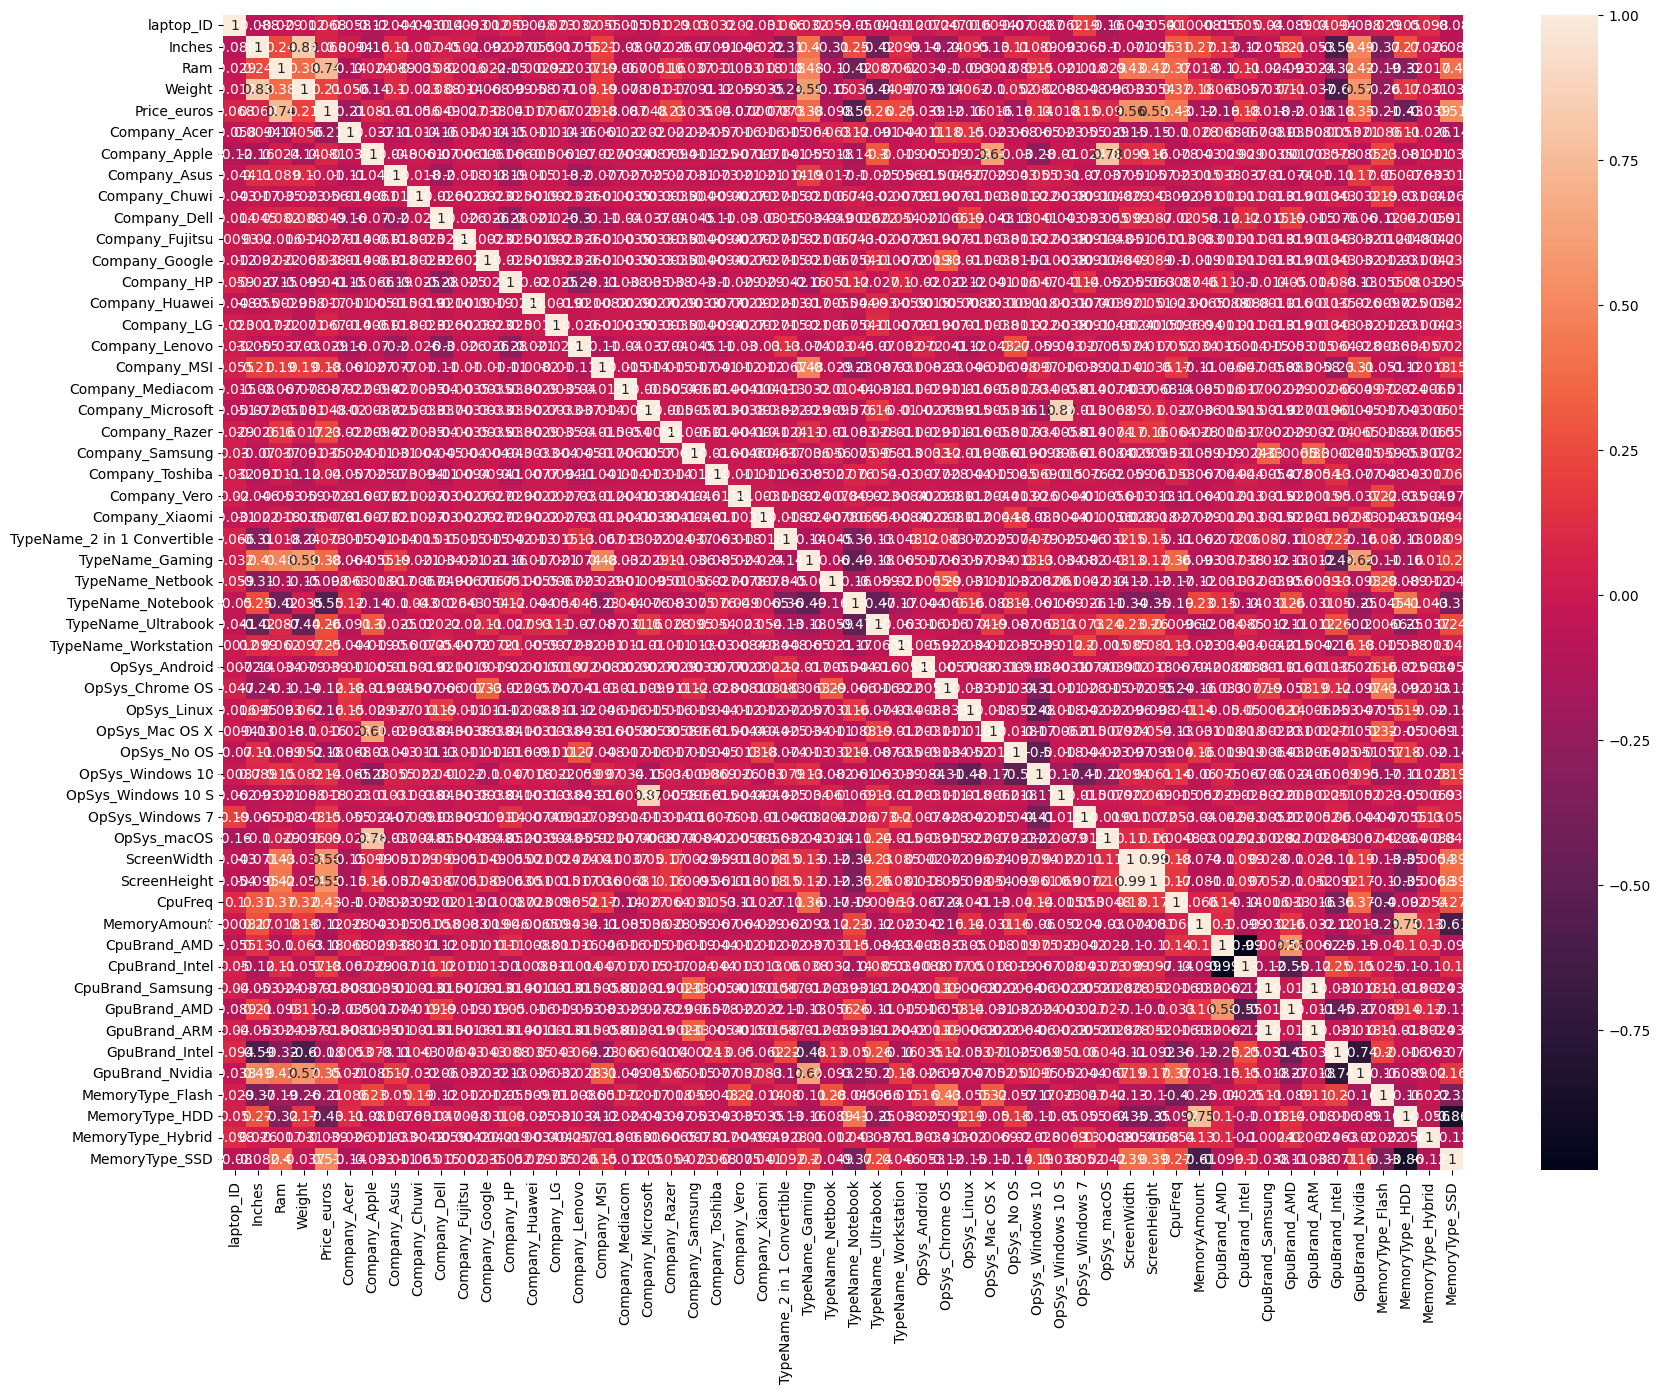

In [37]:
plt.figure(figsize=(20,15))
sns.heatmap(df_encoded.corr(), annot=True)

In [38]:
df_encoded.corr()['Price_euros'].apply(abs).sort_values(ascending=False)

Price_euros                    1.000000
Ram                            0.743007
ScreenWidth                    0.556529
ScreenHeight                   0.552809
TypeName_Notebook              0.549248
MemoryType_SSD                 0.513609
CpuFreq                        0.430293
MemoryType_HDD                 0.426121
TypeName_Gaming                0.375789
GpuBrand_Nvidia                0.348797
TypeName_Ultrabook             0.255658
TypeName_Workstation           0.249752
Company_Razer                  0.233756
MemoryType_Flash               0.210823
Weight                         0.210370
Company_Acer                   0.208349
GpuBrand_AMD                   0.199415
GpuBrand_Intel                 0.184205
CpuBrand_Intel                 0.181127
CpuBrand_AMD                   0.180111
Company_MSI                    0.180100
OpSys_No OS                    0.177094
OpSys_Linux                    0.162060
OpSys_Windows 7                0.152381
OpSys_Windows 10               0.137048


In [39]:
target = df_encoded.corr()['Price_euros'].apply(abs).sort_values(ascending=False)

In [40]:
selected = list(target[:27].index)
selected

['Price_euros',
 'Ram',
 'ScreenWidth',
 'ScreenHeight',
 'TypeName_Notebook',
 'MemoryType_SSD',
 'CpuFreq',
 'MemoryType_HDD',
 'TypeName_Gaming',
 'GpuBrand_Nvidia',
 'TypeName_Ultrabook',
 'TypeName_Workstation',
 'Company_Razer',
 'MemoryType_Flash',
 'Weight',
 'Company_Acer',
 'GpuBrand_AMD',
 'GpuBrand_Intel',
 'CpuBrand_Intel',
 'CpuBrand_AMD',
 'Company_MSI',
 'OpSys_No OS',
 'OpSys_Linux',
 'OpSys_Windows 7',
 'OpSys_Windows 10',
 'MemoryAmount',
 'OpSys_Chrome OS']

In [41]:
limited_df = df_encoded[selected]
limited_df

,Price_euros,Ram,ScreenWidth,ScreenHeight,TypeName_Notebook,MemoryType_SSD,CpuFreq,MemoryType_HDD,TypeName_Gaming,GpuBrand_Nvidia,...,GpuBrand_Intel,CpuBrand_Intel,CpuBrand_AMD,Company_MSI,OpSys_No OS,OpSys_Linux,OpSys_Windows 7,OpSys_Windows 10,MemoryAmount,OpSys_Chrome OS
0,1339.69,8,2560,1600,0.0,1.0,2.3,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,128,0.0
1,898.94,8,1440,900,0.0,0.0,1.8,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,128,0.0
2,575.00,8,1920,1080,1.0,1.0,2.5,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,256,0.0
3,2537.45,16,2880,1800,0.0,1.0,2.7,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,512,0.0
4,1803.60,8,2560,1600,0.0,1.0,3.1,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,256,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,638.00,4,1920,1080,0.0,1.0,2.5,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,128,0.0
1299,1499.00,16,3200,1800,0.0,1.0,2.5,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,512,0.0
1300,229.00,2,1366,768,1.0,0.0,1.6,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,64,0.0
1301,764.00,6,1366,768,1.0,0.0,2.5,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1000,0.0


In [42]:
x = limited_df.drop("Price_euros", axis=1)
y = limited_df["Price_euros"]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [43]:
rfr = RandomForestRegressor()
rfr.fit(x_train_scaled, y_train)
rfr.score(x_test_scaled, y_test)

0.8243608706297473

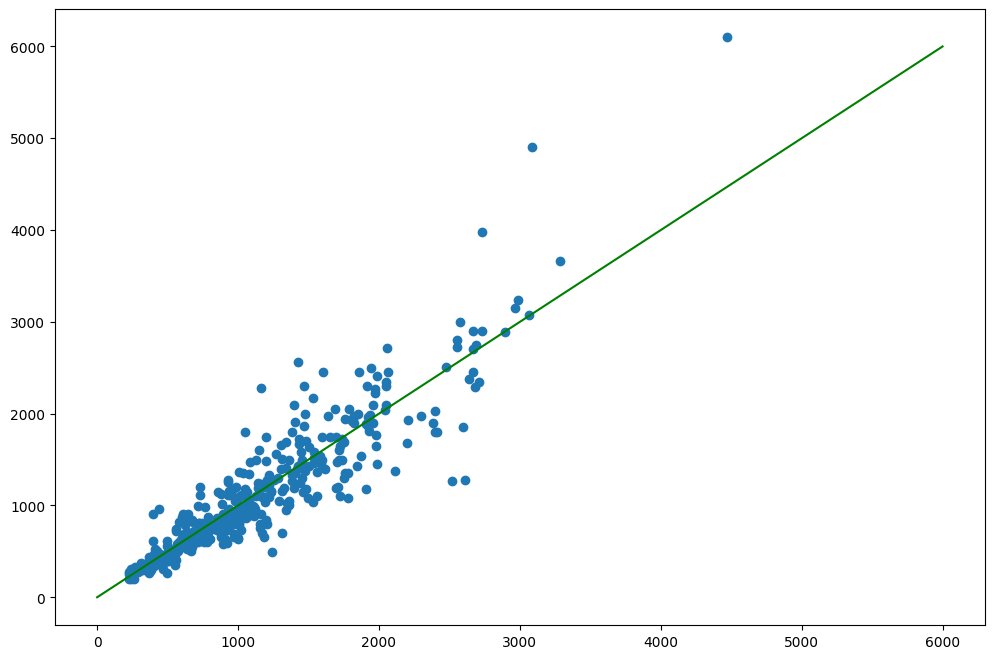

In [44]:
y_prediction = rfr.predict(x_test_scaled)

plt.figure(figsize=(12,8))
plt.scatter(y_prediction, y_test)
plt.plot(range(0,6000), range(0,6000), c='green')